In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'asurv/')
sys.path.append(gh_dir+'linmix/')
import asurv
import linmix

In [2]:
# Setup the figures
style='paper'
execfile('/Users/ttshimiz/Dropbox/Research/figure_setup.py')

In [13]:
# Upload the fitting results for the C12 model
bat_c12 = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])
bat_c12 = bat_c12.drop(radio_loud_sources)
#bat_c12.loc['UGC06728', 'lir_sf'] -= 2.0
#bat_c12.loc['UGC06728', 'mdust'] -= 2.0
#bat_c12.loc['2MASXiJ1802473-145454', 'lir_sf'] -= 2.046
#bat_c12.loc['2MASXiJ1802473-145454', 'mdust'] -= 2.046

# Add in quadrature an uncertainty of 0.15 for f_AGN and 0.2 dex for the luminosities
bat_c12['agn_frac_err_high'] = np.sqrt(bat_c12['agn_frac_err_high']**2 + 0.15**2)
bat_c12['agn_frac_err_low'] = np.sqrt(bat_c12['agn_frac_err_low']**2 + 0.15**2)
bat_c12['lir_sf_err_high'] = np.sqrt(bat_c12['lir_sf_err_high']**2 + 0.2**2)
bat_c12['lir_sf_err_low'] = np.sqrt(bat_c12['lir_sf_err_low']**2 + 0.2**2)
bat_c12['lir_agn_err_high'] = np.sqrt(bat_c12['lir_agn_err_high']**2 + 0.2**2)
bat_c12['lir_agn_err_low'] = np.sqrt(bat_c12['lir_agn_err_low']**2 + 0.2**2)

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
bat_c12['Redshift'] = bat_info['Redshift']

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_c12['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))


# Calculate the SFR
bat_c12['sfr'] = bat_c12['lir_sf'] + np.log10(3.846e33) - np.log10(2.57e43)
bat_c12['sfr_68_up'] = bat_c12['lir_sf_err_high']
bat_c12['sfr_68_down'] = bat_c12['lir_sf_err_low']
bat_c12['sfr_err'] = np.max(np.vstack([bat_c12['sfr_68_up'], bat_c12['sfr_68_down']]), axis=0)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['bat_flux_err_low'] = bat_flux['BAT_flux'] - bat_flux['BAT_flux_90_low']
bat_flux['bat_flux_err_high'] = bat_flux['BAT_flux_90_high'] - bat_flux['BAT_flux']
bat_flux['lbat'] = np.log10(4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12))
bat_flux['bat_err'] = np.max(np.vstack([bat_flux['bat_flux_err_low'], bat_flux['bat_flux_err_high']]), axis=0)
bat_flux['lbat_err'] = 0.434*4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['bat_err']*10**(-12)/(10**bat_flux['lbat'])
bat_flux['lbat_flag'] = pd.Series(index=bat_flux.index)
bat_flux.loc[bat_flux['BAT_flux_90_high'] == 0, 'lbat_flag'] = 0
bat_flux.loc[bat_flux['BAT_flux_90_low'] != 0, 'lbat_flag'] = 1
bat_flux.loc[bat_flux['lbat_flag'] == 0, 'lbat_err'] = 0

bat_c12['lbat'] = bat_flux['lbat']
bat_c12['lbat_err'] = bat_flux['lbat_err']
bat_c12['lbat_flag'] = bat_flux['lbat_flag']
bat_c12['lbol'] = 1.1157*bat_c12['lbat'] - 4.2280
bat_c12['lbol_err'] = 1.1157*bat_c12['lbat_err']

In [4]:
broad_type = pd.Series(index=bat_info.index, name='Sy_Type')

for n in bat_info.index.values:

    type_split = bat_info.loc[n, 'Seyfert_Type'].split()

    if ((type_split[0] == 'Sy')):
        if ((type_split[1] == '1') | (type_split[1] == '1.2') | (type_split[1] == '1.4') | (type_split[1] == '1.5')):

            broad_type.loc[n] = 'Sy 1'
            
        elif ((type_split[1] == '2') | (type_split[1] == '1.8') | (type_split[1] == '1.9')):
            
            broad_type.loc[n] = 'Sy 2'
    else:

        if (type_split[0] == 'LINER'):
            
            broad_type.loc[n] = 'LINER'

        elif (type_split[0] == 'AGN'):
            
            broad_type.loc[n] = 'AGN'

In [5]:
bat_c12['Sy_Type'] = broad_type
bat_sy1 = bat_c12[bat_c12['Sy_Type'] == 'Sy 1']
bat_sy2 = bat_c12[bat_c12['Sy_Type'] == 'Sy 2']

In [62]:
x = bat_c12['lbat'].values
y = bat_c12['sfr'].values
xerr = bat_c12['lbat_err'].values
yerr = bat_c12['sfr_err'].values
yerr[np.isnan(yerr)] = np.mean(yerr[np.isfinite(yerr)])
delta = bat_c12['lir_sf_flag'].values
delta[delta == 1] = 0
delta = delta + 1

lm = linmix.LinMix(x=x, y=y, xsig=xerr, ysig=yerr, delta=delta)
lm.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm.chain['beta']), ' +/- ', np.std(lm.chain['beta'])
print 'Intercept = ', np.median(lm.chain['alpha']), ' +/- ', np.std(lm.chain['alpha'])
print 'Sigsqr = ', np.median(lm.chain['sigsqr']), ' +/- ', np.std(lm.chain['sigsqr'])
print 'R^2 = ', np.median(lm.chain['corr']), ' +/- ', np.std(lm.chain['corr'])

Total Sample:
Slope =  0.184608260526  +/-  0.0673013025891
Intercept =  -7.84434006284  +/-  2.92071264123
Sigsqr =  0.36948351989  +/-  0.0384718571449
R^2 =  0.170873577533  +/-  0.0636125614771


In [15]:
x_sy1 = bat_sy1['lbat'].values
y_sy1 = bat_sy1['sfr'].values
xerr_sy1 = bat_sy1['lbat_err'].values
yerr_sy1 = bat_sy1['sfr_err'].values
yerr_sy1[np.isnan(yerr_sy1)] = np.mean(yerr[np.isfinite(yerr_sy1)])
delta_sy1 = bat_sy1['lir_sf_flag'].values
delta_sy1[delta_sy1 == 1] = 0
delta_sy1 = delta_sy1 + 1

lm_sy1 = linmix.LinMix(x=x_sy1, y=y_sy1, xsig=xerr_sy1, ysig=yerr_sy1, delta=delta_sy1)
lm_sy1.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm_sy1.chain['beta']), ' +/- ', np.std(lm_sy1.chain['beta'])
print 'Intercept = ', np.median(lm_sy1.chain['alpha']), ' +/- ', np.std(lm_sy1.chain['alpha'])
print 'Sigsqr = ', np.median(lm_sy1.chain['sigsqr']), ' +/- ', np.std(lm_sy1.chain['sigsqr'])
print 'R^2 = ', np.median(lm_sy1.chain['corr']), ' +/- ', np.std(lm_sy1.chain['corr'])

Total Sample:
Slope =  0.337029666753  +/-  0.126916024725
Intercept =  -14.6841890981  +/-  5.52772399661
Sigsqr =  0.494782486621  +/-  0.0828754381525
R^2 =  0.247523293961  +/-  0.09466909991


/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 306 but corresponding boolean dimension is 135


In [14]:
x_sy2 = bat_sy2['lbat'].values
y_sy2 = bat_sy2['sfr'].values
xerr_sy2 = bat_sy2['lbat_err'].values
yerr_sy2 = bat_sy2['sfr_err'].values
yerr_sy2[np.isnan(yerr_sy2)] = np.mean(yerr[np.isfinite(yerr_sy2)])
delta_sy2 = bat_sy2['lir_sf_flag'].values
delta_sy2[delta_sy2 == 1] = 0
delta_sy2 = delta_sy2 + 1

lm_sy2 = linmix.LinMix(x=x_sy2, y=y_sy2, xsig=xerr_sy2, ysig=yerr_sy2, delta=delta_sy2)
lm_sy2.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm_sy2.chain['beta']), ' +/- ', np.std(lm_sy2.chain['beta'])
print 'Intercept = ', np.median(lm_sy2.chain['alpha']), ' +/- ', np.std(lm_sy2.chain['alpha'])
print 'Sigsqr = ', np.median(lm_sy2.chain['sigsqr']), ' +/- ', np.std(lm_sy2.chain['sigsqr'])
print 'R^2 = ', np.median(lm_sy2.chain['corr']), ' +/- ', np.std(lm_sy2.chain['corr'])

Total Sample:
Slope =  0.189758865999  +/-  0.0775596481298
Intercept =  -7.93903889521  +/-  3.35625049004
Sigsqr =  0.257971836099  +/-  0.0373800853067
R^2 =  0.209238305698  +/-  0.0857530547896


/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 306 but corresponding boolean dimension is 166


In [64]:
xfit = np.arange(41.0, 49.0, 0.001)
yfit_all = np.zeros((len(lm.chain['beta']), len(xfit)))
#yfit_sy1 = np.zeros((len(lm_sy1.chain['beta']), len(xfit)))
#yfit_sy2 = np.zeros((len(lm_sy2.chain['beta']), len(xfit)))

for i in range(len(lm.chain['beta'])):
    beta_i = lm.chain['beta'][i]
    alpha_i = lm.chain['alpha'][i]
    yfit_all[i, :] = alpha_i + beta_i*xfit

    #beta_sy1_i = lm_sy1.chain['beta'][i]
    #alpha_sy1_i = lm_sy1.chain['alpha'][i]
    #yfit_sy1[i, :] = alpha_sy1_i + beta_sy1_i*xfit
    
    #beta_sy2_i = lm_sy2.chain['beta'][i]
    #alpha_sy2_i = lm_sy2.chain['alpha'][i]
    #yfit_sy2[i, :] = alpha_sy2_i + beta_sy2_i*xfit


yfit_median = np.median(yfit_all, axis=0)
yfit_upper95 = np.percentile(yfit_all, axis=0, q=97.5)
yfit_lower95 = np.percentile(yfit_all, axis=0, q=2.5)

#yfit_sy1_median = np.median(yfit_sy1, axis=0)
#yfit_sy1_upper95 = np.percentile(yfit_sy1, axis=0, q=97.5)
#yfit_sy1_lower95 = np.percentile(yfit_sy1, axis=0, q=2.5)

#yfit_sy2_median = np.median(yfit_sy2, axis=0)
#yfit_sy2_upper95 = np.percentile(yfit_sy2, axis=0, q=97.5)
#yfit_sy2_lower95 = np.percentile(yfit_sy2, axis=0, q=2.5)

NameError: name 'yfit_sy1_median' is not defined

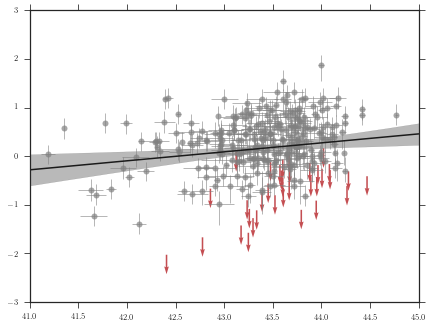

In [8]:
fig = plt.figure(figsize=(textwidth, 3./4.*textwidth))
#fig = plt.figure(figsize=(6, 4.5))
ax = fig.add_subplot(111)
#plt.errorbar(x_sy1[delta_sy1==1], y_sy1[delta_sy1==1], xerr=xerr_sy1[delta_sy1==1], yerr=bat_sy1.loc[delta_sy1==1, ['sfr_68_up', 'sfr_68_down']].values.transpose(),
#             fmt='o', color='b', ls='None', alpha=0.6, label='Type 1')
#plt.errorbar(x_sy2[delta_sy2==1], y_sy2[delta_sy2==1], xerr=xerr_sy2[delta_sy2==1], yerr=bat_sy2.loc[delta_sy2==1, ['sfr_68_up', 'sfr_68_down']].values.transpose(),
#             fmt='o', color='r', ls='None', alpha=0.6, label='Type 2')
#plt.plot(x_sy1[delta_sy1==0], y_sy1[delta_sy1==0], marker='v', markeredgecolor='b', markerfacecolor='None',
#         markeredgewidth=1.5, ls='None', alpha=0.6, ms=8)
#plt.plot(x_sy2[delta_sy2==0], y_sy2[delta_sy2==0], marker='v', markeredgecolor='r', markerfacecolor='None',
#         markeredgewidth=1.5, ls='None', alpha=0.6, ms=8)

ax.errorbar(x[delta==1], y[delta==1], xerr=xerr[delta==1],
            yerr=bat_c12.loc[delta==1, ['sfr_68_down', 'sfr_68_up']].values.transpose(),
            fmt='o', color='grey', ls='None', ecolor='grey', elinewidth=0.8, ms=6, alpha=0.7, label='Individual Sources')
ax.quiver(x[delta==0], y[delta==0], np.zeros(sum(delta==0)), -np.ones(sum(delta==0)),
          scale_units='height', scale=15., units='width', width=0.004, color='r', pivot='tail', label='_nolabel')
plt.plot(xfit, yfit_median, 'k-', lw=1.5, label='Linear Fit: All')
plt.fill_between(xfit, yfit_lower95, yfit_upper95, color='k', alpha=0.3, label='_nolabel')
plt.plot(xfit, yfit_sy1_median, 'b-', lw=1.5, label='Linear Fit: Type 1')
plt.fill_between(xfit, yfit_sy1_lower95, yfit_sy1_upper95, color='b', alpha=0.3, label='_nolabel')
plt.plot(xfit, yfit_sy2_median, 'r-', lw=1.5, label='Linear Fit: Type 2')
plt.fill_between(xfit, yfit_sy2_lower95, yfit_sy2_upper95, color='r', alpha=0.3, label='_nolabel')

#hickox_model = np.loadtxt('../data/hickox14_lir_v_lagn.csv', delimiter=',')
#hickox_sfr = hickox_model[:,1]-np.log10(2.57e43)
#hickox_agn = (hickox_model[:,0] + 4.2280)/1.1157
#plt.plot(hickox_agn, hickox_sfr, 'k--', lw=1.5, label='Hickox+14 Model')

#lbol = np.arange(41.5, 46.0, 0.01)
#lsf_rosario = np.log10(10**(43.57) + 10**(43.57)*(10**lbol/10**(44.27))**0.78)
#lsf_netzer = 41+0.8*(lbol-41)
#lbat_model = (lbol+4.2280)/1.1157
#c = 0.140904716825
#plt.plot(lbat_model, lsf_rosario-np.log10(2.57e43)+c, 'g-', lw=1.5, label='Rosario+12')
#plt.plot(lbat_model, lsf_netzer-np.log10(2.57e43)+c, 'g--', lw=1.5, label='Netzer+09')
plt.xlim(41.0, 45.0)
plt.ylim(-2.5, 2)
plt.xlabel(r'$\log\,L_{\mathdefault{14-195\,keV}}$ [ergs s$^{-1}$]')
plt.ylabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
plt.legend(loc='upper left', fontsize=10)
#ax.axhline(0.22)
sn.despine()
ax.tick_params(axis='both', which='major', labelsize=10)
#fig.savefig(figsave_dir+'sfr_lbat_correlation_nosy.pdf', bbox_inches='tight')
#fig.savefig('/Users/ttshimiz/Dropbox/Research/Thesis/Dissertation/Chapter3/sfr_lbat_correlation_nosy.pdf', bbox_inches='tight')

In [17]:
bin_edges = np.array([42.0, 42.5, 43.0, 43.5, 44.0])
n_bins = len(bin_edges) + 1

avg_sfr = pd.Series(index=np.arange(n_bins))
avg_sfr_mn_err = pd.Series(index=np.arange(n_bins))
avg_sfr_err_up = pd.Series(index=np.arange(n_bins))
avg_sfr_err_down = pd.Series(index=np.arange(n_bins))
avg_lx = pd.Series(index=np.arange(n_bins))
avg_lx_err_up = pd.Series(index=np.arange(n_bins))
avg_lx_err_down = pd.Series(index=np.arange(n_bins))

for i in range(n_bins):
    
    if i == 0:
        ind = bat_c12['lbat'] <= bin_edges[i]
    elif i == (n_bins - 1):
        ind = bat_c12['lbat'] > bin_edges[-1]
    else:
        ind = (bat_c12['lbat'] > bin_edges[i-1]) & (bat_c12['lbat'] <= bin_edges[i])
        
    data = bat_c12.loc[ind, 'sfr'].values
    flag = bat_c12.loc[ind, 'lir_sf_flag'].values
    cens= np.ones(len(data))
    cens[flag == -1] = 0
    
    km = asurv.KaplanMeierDist(data=data, cens=cens)
    mn, mn_err = km.km_mean()
    med = km.km_percentile(0.5)
    p16 = km.km_percentile(0.16)
    p84 = km.km_percentile(0.84)
    
    avg_sfr.loc[i] = mn
    avg_sfr_mn_err.loc[i] = mn_err
    avg_sfr_err_up.loc[i] = p84-mn
    avg_sfr_err_down.loc[i] = mn-p16
    
    avg_lx.loc[i] = bat_c12.loc[ind, 'lbat'].mean()
    avg_lx_err_up.loc[i] = bat_c12.loc[ind, 'lbat'].max() - avg_lx.loc[i]
    avg_lx_err_down.loc[i] = avg_lx.loc[i] - bat_c12.loc[ind, 'lbat'].min()

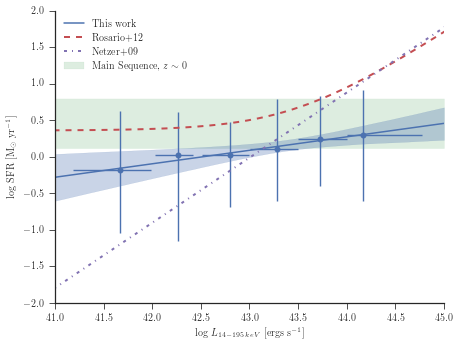

In [12]:
fig = plt.figure(figsize=(textwidth, 3./4.*textwidth))
#fig = plt.figure(figsize=(7, 6))

ax = fig.add_subplot(111)
ax.fill_between(xfit, 0.12*np.ones(len(xfit)), 0.80*np.ones(len(xfit)), color='g', alpha=0.2, label=r'Main Sequence, $z\sim0$')
#ax.plot(x[delta==1], y[delta==1],
#            marker='o', color='grey', ls='None', ms=6, alpha=0.5, label='Individual Sources')
#ax.quiver(x[delta==0], y[delta==0], np.zeros(sum(delta==0)), -np.ones(sum(delta==0)),
#          scale_units='height', scale=15., units='width', width=0.004, color='gray',
#          pivot='tail', label='_nolabel', alpha=0.5)
ax.errorbar(avg_lx, avg_sfr,
            xerr = np.vstack([avg_lx_err_down, avg_lx_err_up]),
            yerr=np.vstack([avg_sfr_err_down.values, avg_sfr_err_up.values]),
            fmt='o', color='b', ls='None', ms=6)
ax.plot(xfit, yfit_median, 'b-', lw=1.5, label=r'This work')
ax.fill_between(xfit, yfit_lower95, yfit_upper95, color='b', alpha=0.3)

#hickox_model = np.loadtxt('../data/hickox14_lir_v_lagn.csv', delimiter=',')
#hickox_sfr = hickox_model[:,1]-np.log10(2.57e43)
#hickox_agn = (hickox_model[:,0] + 4.2280)/1.1157
#ax.plot(hickox_agn, hickox_sfr, 'k--', lw=1.5, label='Hickox+14 Model')

lbol = np.arange(41.5, 46.0, 0.01)
lsf_rosario = np.log10(10**(43.57) + 10**(43.57)*(10**lbol/10**(44.27))**0.78)
lsf_netzer = 41+0.8*(lbol-41)
lbat_model = (lbol+4.2280)/1.1157
#c = 0.140904716825
c = 0.20
ax.plot(lbat_model, lsf_rosario-np.log10(2.57e43)+c, 'r--', lw=2.0, label='Rosario+12')
ax.plot(lbat_model, lsf_netzer-np.log10(2.57e43)+c, 'm-.', lw=2.0, label='Netzer+09')

ax.set_xlim(41.0, 45.0)
ax.set_ylim(-2, 2.0)
ax.set_xlabel(r'$\log\,L_{\mathdefault{14-195\,keV}}$ [ergs s$^{-1}$]')
ax.set_ylabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
ax.legend(loc='upper left', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
sn.despine()
#fig.savefig('../figures/lbat_sfr_correlation_compare_lit_with_MS.pdf', bbox_inches='tight')

In [18]:
bat_c12[bat_c12['sfr'] < -1.5]

,mdust,mdust_err_high,mdust_err_low,mdust_flag,tdust,tdust_err_high,tdust_err_low,tdust_flag,alpha,alpha_err_high,...,Redshift,Mstar,sfr,sfr_68_up,sfr_68_down,sfr_err,lbat,lbat_err,lbat_flag,Sy_Type
Name,,,,,,,,,,,,,,,,,,,,,
2MASXJ13512953-1813468,5.496721,NaN,NaN,-1,NaN,NaN,NaN,NaN,0.837321,0.562498,...,0.012218,NaN,-1.668007,NaN,NaN,0.229706,42.777090,0.125006,1,Sy 1
UGC06728,5.095617,NaN,NaN,-1,NaN,NaN,NaN,NaN,1.239156,0.396037,...,0.006500,NaN,-2.026042,NaN,NaN,0.229706,42.407322,0.052974,1,Sy 1
WKK6092,5.586555,NaN,NaN,-1,NaN,NaN,NaN,NaN,1.611523,0.362227,...,0.015637,NaN,-1.574491,NaN,NaN,0.229706,43.248465,0.065201,1,Sy 1


In [8]:
bat_c12['dlogMS'] = bat_c12['sfr'] - (1.01*bat_c12['Mstar'] - 9.87)
bat_c12['sSFR'] = bat_c12['sfr'] - bat_c12['Mstar']

In [10]:
sfr_ms = bat_c12['sfr'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
sfr_err_ms = bat_c12['sfr_err'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
lx_ms = bat_c12['lbat'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
lx_err_ms = bat_c12['lbat_err'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values
delta_ms = bat_c12['lir_sf_flag'][(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64)].values + 1

#sfr_ms = sfr_ms[lx_ms < 44.5]
#sfr_err_ms = sfr_err_ms[lx_ms < 44.5]
#lx_err_ms = lx_err_ms[lx_ms < 44.5]
#delta_ms = delta_ms[lx_ms < 44.5]
#lx_ms = lx_ms[lx_ms < 44.5]
lm_ms = linmix.LinMix(x=lx_ms, y=sfr_ms, xsig=lx_err_ms, ysig=sfr_err_ms, delta=delta_ms)
lm_ms.run_mcmc(silent=True)

In [11]:
sfr_below2 = bat_c12['sfr'][(bat_c12['dlogMS'] < -0.64)].values
sfr_err_below2 = bat_c12['sfr_err'][(bat_c12['dlogMS'] < -0.64)].values
lx_below2 = bat_c12['lbat'][(bat_c12['dlogMS'] < -0.64)].values
lx_err_below2 = bat_c12['lbat_err'][(bat_c12['dlogMS'] < -0.64)].values
delta_below2 = bat_c12['lir_sf_flag'][(bat_c12['dlogMS'] < -0.64)].values + 1

lm_below2 = linmix.LinMix(x=lx_below2, y=sfr_below2, xsig=lx_err_below2, ysig=sfr_err_below2, delta=delta_below2)
lm_below2.run_mcmc(silent=True)

In [63]:
xfit = np.arange(41.0, 49.0, 0.001)
yfit_ms = np.zeros((len(lm_ms.chain['beta']), len(xfit)))
yfit_below2 = np.zeros((len(lm_below2.chain['beta']), len(xfit)))

for i in range(len(lm_ms.chain['beta'])):
    beta_ms_i = lm_ms.chain['beta'][i]
    alpha_ms_i = lm_ms.chain['alpha'][i]
    yfit_ms[i, :] = alpha_ms_i + beta_ms_i*xfit

    beta_below2_i = lm_below2.chain['beta'][i]
    alpha_below2_i = lm_below2.chain['alpha'][i]
    yfit_below2[i, :] = alpha_below2_i + beta_below2_i*xfit


yfit_ms_median = np.median(yfit_ms, axis=0)
yfit_ms_upper95 = np.percentile(yfit_ms, axis=0, q=97.5)
yfit_ms_lower95 = np.percentile(yfit_ms, axis=0, q=2.5)

yfit_below2_median = np.median(yfit_below2, axis=0)
yfit_below2_upper95 = np.percentile(yfit_below2, axis=0, q=97.5)
yfit_below2_lower95 = np.percentile(yfit_below2, axis=0, q=2.5)

NameError: name 'lm_ms' is not defined

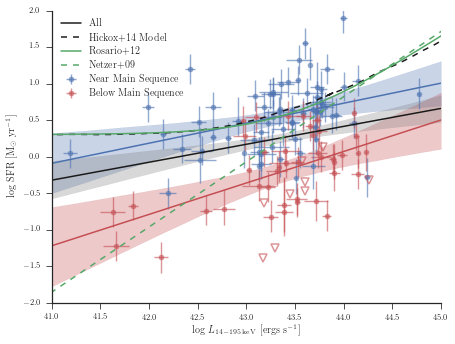

In [16]:
fig = plt.figure(figsize=(textwidth, 3./4.*textwidth))
plt.errorbar(lx_ms, sfr_ms, xerr=lx_err_ms, yerr=bat_c12.loc[(bat_c12['dlogMS'] < 0.64) & (bat_c12['dlogMS'] > -0.64), ['sfr_68_up', 'sfr_68_down']].values.transpose(),
             fmt='o', color='b', ls='None', alpha=0.6, label='Near Main Sequence')
plt.errorbar(lx_below2[delta_below2==1], sfr_below2[delta_below2==1], xerr=lx_err_below2[delta_below2==1], yerr=bat_c12.loc[(bat_c12['dlogMS'] < -0.64), ['sfr_68_up', 'sfr_68_down']][delta_below2==1].values.transpose(),
             fmt='o', color='r', ls='None', alpha=0.6, label='Below Main Sequence')
plt.plot(lx_below2[delta_below2==0], sfr_below2[delta_below2==0], marker='v', markeredgecolor='r', markerfacecolor='None',
         markeredgewidth=1.5, ls='None', alpha=0.6, ms=8)
plt.plot(xfit, yfit_ms_median, 'b-', lw=1.5)
plt.fill_between(xfit, yfit_ms_lower95, yfit_ms_upper95, color='b', alpha=0.3)
plt.plot(xfit, yfit_below2_median, 'r-', lw=1.5)
plt.fill_between(xfit, yfit_below2_lower95, yfit_below2_upper95, color='r', alpha=0.3)
plt.plot(xfit, yfit_median, 'k-', lw=1.5, label='All')
plt.fill_between(xfit, yfit_lower95, yfit_upper95, color='grey', alpha=0.3)

hickox_model = np.loadtxt('../data/hickox14_lir_v_lagn.csv', delimiter=',')
hickox_sfr = hickox_model[:,1]-np.log10(2.57e43)
hickox_agn = (hickox_model[:,0] + 4.2280)/1.1157

lbol = np.arange(41.5, 46.0, 0.01)
lsf_rosario = np.log10(10**(43.57) + 10**(43.57)*(10**lbol/10**(44.27))**0.78)
lsf_netzer = 41+0.8*(lbol-41)
lbat_model = (lbol+4.2280)/1.1157
c = 0.140904716825
plt.plot(hickox_agn, hickox_sfr, 'k--', lw=1.5, label='Hickox+14 Model')
plt.plot(lbat_model, lsf_rosario-np.log10(2.57e43)+c, 'g-', lw=1.5, label='Rosario+12')
plt.plot(lbat_model, lsf_netzer-np.log10(2.57e43)+c, 'g--', lw=1.5, label='Netzer+09')

plt.xlim(41.0, 45.0)
plt.ylim(-2, 2)
plt.xlabel(r'$\log\,L_{\rm 14-195\,keV}$ [ergs s$^{-1}$]')
plt.ylabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
plt.legend(loc='upper left', fontsize=10)
sn.despine()
fig.savefig(figsave_dir+'sfr_lbat_correlation_split_main_seqeunce.pdf', bbox_inches='tight')

In [42]:
print 'Near MS Sample:'
print 'Slope = ', np.median(lm_ms.chain['beta']), ' +/- ', np.std(lm_ms.chain['beta'])
print 'Intercept = ', np.median(lm_ms.chain['alpha']), ' +/- ', np.std(lm_ms.chain['alpha'])
print 'Sigsqr = ', np.median(lm_ms.chain['sigsqr']), ' +/- ', np.std(lm_ms.chain['sigsqr'])
print 'R^2 = ', np.median(lm_ms.chain['corr']), ' +/- ', np.std(lm_ms.chain['corr'])

Near MS Sample:
Slope =  0.274938651065  +/-  0.0877017082635
Intercept =  -11.3667132312  +/-  3.80093815878
Sigsqr =  0.163943937827  +/-  0.0332050056688
R^2 =  0.382399134901  +/-  0.117924515304


In [43]:
print 'Below MS Sample:'
print 'Slope = ', np.median(lm_below2.chain['beta']), ' +/- ', np.std(lm_below2.chain['beta'])
print 'Intercept = ', np.median(lm_below2.chain['alpha']), ' +/- ', np.std(lm_below2.chain['alpha'])
print 'Sigsqr = ', np.median(lm_below2.chain['sigsqr']), ' +/- ', np.std(lm_below2.chain['sigsqr'])
print 'R^2 = ', np.median(lm_below2.chain['corr']), ' +/- ', np.std(lm_below2.chain['corr'])

Below MS Sample:
Slope =  0.432210042076  +/-  0.110914190916
Intercept =  -18.9311323297  +/-  4.81223633049
Sigsqr =  0.190962233785  +/-  0.0528734223191
R^2 =  0.520525551713  +/-  0.128469204649


In [93]:
bat_c12[((bat_c12['lbat']) < 42.25) & (bat_c12['sfr'] <0.0)]

,mdust,mdust_err_high,mdust_err_low,mdust_flag,tdust,tdust_err_high,tdust_err_low,tdust_flag,alpha,alpha_err_high,...,Redshift,Mstar,sfr,sfr_68_up,sfr_68_down,sfr_err,lbat,lbat_err,lbat_flag,Sy_Type
Name,,,,,,,,,,,,,,,,,,,,,
IC2461,7.093235,0.079094,0.103027,0,19.293414,1.377373,1.005453,0,2.305960,0.291956,...,0.007539,9.470644,-0.496972,0.216717,0.208566,0.083465,42.191278,0.088500,1,Sy 2
NGC1052,6.360464,0.137993,0.162568,0,18.160784,1.714244,1.340894,0,1.569378,0.348421,...,0.005037,10.555279,-1.381072,0.215888,0.215056,0.081288,42.123963,0.070124,1,Sy 2
NGC2655,7.045785,0.415053,0.154401,0,20.612969,1.750476,4.280217,0,1.441451,0.846766,...,0.004670,NaN,-0.374552,0.211705,0.272108,0.184507,41.960680,0.132396,1,Sy 2
NGC3718,7.028733,0.591845,0.084467,0,17.945148,0.543096,4.138958,0,0.328068,1.695533,...,0.003312,10.320196,-0.763807,0.201703,0.211985,0.070269,41.627545,0.127077,1,Sy 2
NGC4138,6.631499,0.032799,0.032718,0,21.526008,0.278430,0.307629,0,0.344721,0.490081,...,0.002962,9.877322,-0.673671,0.200633,0.200798,0.017879,41.836006,0.054829,1,Sy 2
NGC4941,7.382095,0.058916,0.063186,0,14.298952,0.398577,0.363011,0,1.502155,0.291247,...,0.003696,NaN,-0.988066,0.201034,0.201308,0.022910,41.682076,0.106112,1,Sy 2
NGC5273,5.464440,0.071563,0.062150,0,27.202459,0.795725,1.138763,0,1.320437,0.469419,...,0.003549,9.821571,-1.232178,0.202455,0.205964,0.049204,41.657422,0.136035,1,Sy 1
NGC7213,6.916172,0.065857,0.066908,0,20.257244,0.861989,0.820564,0,1.243422,0.337410,...,0.005839,NaN,-0.545396,0.205428,0.205256,0.046912,42.026145,0.048761,1,Sy 2
NGC7465,6.733795,0.042931,0.040659,0,26.533049,0.522478,0.562465,0,1.240628,0.472083,...,0.006565,NaN,-0.024991,0.200942,0.201502,0.024554,42.088780,0.141885,1,LINER


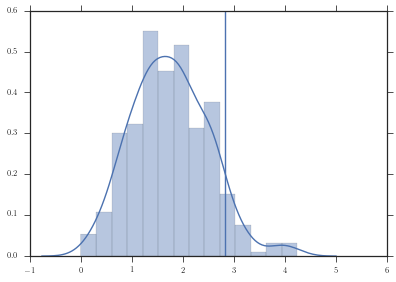

In [26]:
bat_lbol = x*1.1157-4.2280
bat_lsf = y + np.log10(2.57e43)
bat_accretion_rate = bat_lbol - np.log10(0.1) - np.log10(3e10**2) - np.log10(2e33)+np.log10(86400.*365.)
sn.distplot(y-bat_accretion_rate)
plt.axvline(np.log10(1/1.5e-3))

In [27]:
Slope =  0.241116993326  +/-  0.0543287505373
Intercept =  -10.2069388483  +/-  2.35668018467
Sigsqr =  0.213284447026  +/-  0.0242300402734
R^2 =  0.283882502361  +/-  0.0644440519431

0.017963080001216391

In [ ]:
Total Sample:
Slope =  0.274503859201  +/-  0.0541225381377
Intercept =  -11.6134977075  +/-  2.34787971077
Sigsqr =  0.201745769233  +/-  0.0229881974809
R^2 =  0.328849880074  +/-  0.0643015312713

In [11]:
bat_c12['Mstar'].median()

10.572292253126498

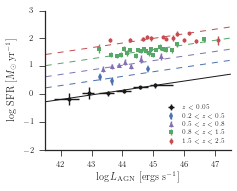

In [68]:
# Upload the Stanley+15 data
stanley15 = pd.read_csv('../data/stanley15_lir_lagn.csv')

# Break up into the redshift bins
z1 = (stanley15['Redshift'] > 0.2) & (stanley15['Redshift'] < 0.5)
z2 = (stanley15['Redshift'] > 0.5) & (stanley15['Redshift'] < 0.8)
z3 = (stanley15['Redshift'] > 0.8) & (stanley15['Redshift'] < 1.5)
z4 = (stanley15['Redshift'] > 1.5) & (stanley15['Redshift'] < 2.5)

bat_avg_lbol = avg_lx*1.1157 - 4.2280
bat_avg_sfr = avg_sfr


fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))

ax = fig.add_subplot(111)

ax.errorbar(bat_avg_lbol, bat_avg_sfr, xerr = np.vstack([avg_lx_err_down, avg_lx_err_up]),
            yerr=avg_sfr_mn_err,
            fmt='o', color='k', ls='None', ms=4, label=r'$z<0.05$')
ax.errorbar(np.log10(stanley15['LAGN(x10^43)'][z1])+43, np.log10(stanley15['SFR'][z1]),
            yerr=np.vstack([0.434*stanley15['SFR_err_low'][z1]/stanley15['SFR'][z1],
                            0.434*stanley15['SFR_err_high'][z1]/stanley15['SFR'][z1]]),
            fmt='d', color='b', ls='None', ms=5, label=r'$0.2 < z < 0.5$')

ax.errorbar(np.log10(stanley15['LAGN(x10^43)'][z2])+43, np.log10(stanley15['SFR'][z2]),
            yerr=np.vstack([0.434*stanley15['SFR_err_low'][z2]/stanley15['SFR'][z2],
                            0.434*stanley15['SFR_err_high'][z2]/stanley15['SFR'][z2]]),
            fmt='^', color='m', ls='None', ms=5, label=r'$0.5 < z < 0.8$')

ax.errorbar(np.log10(stanley15['LAGN(x10^43)'][z3])+43, np.log10(stanley15['SFR'][z3]),
            yerr=np.vstack([0.434*stanley15['SFR_err_low'][z3]/stanley15['SFR'][z3],
                            0.434*stanley15['SFR_err_high'][z3]/stanley15['SFR'][z3]]),
            fmt='s', color='g', ls='None', ms=4, label=r'$0.8 < z < 1.5$')

ax.errorbar(np.log10(stanley15['LAGN(x10^43)'][z4])+43, np.log10(stanley15['SFR'][z4]),
            yerr=np.vstack([0.434*stanley15['SFR_err_low'][z4]/stanley15['SFR'][z4],
                            0.434*stanley15['SFR_err_high'][z4]/stanley15['SFR'][z4]]),
            fmt='o', color='r', ls='None', ms=4, label=r'$1.5 < z < 2.5$')
ax.plot(xfit*1.1157-4.2280, yfit_median, 'k-', lw=1.0, label=r'_nolabel')
ax.plot(xfit*1.1157-4.2280, yfit_median+0.5, 'b--', lw=1.0, label=r'_nolabel')
ax.plot(xfit*1.1157-4.2280, yfit_median+0.9, 'm--', lw=1.0, label=r'_nolabel')
ax.plot(xfit*1.1157-4.2280, yfit_median+1.3, 'g--', lw=1.0, label=r'_nolabel')
ax.plot(xfit*1.1157-4.2280, yfit_median+1.7, 'r--', lw=1.0, label=r'_nolabel')

ax.set_xlim(41.5, 47.5)
ax.set_ylim(-2, 3.0)
ax.set_xlabel(r'$\log L_{\rm AGN}$ [ergs s$^{-1}$]')
ax.set_ylabel(r'$\log$ SFR [$M_{\odot}$ yr$^{-1}$]')
ax.legend(loc='lower right', fontsize=6)
sn.despine()
fig.savefig('../figures/lagn_sfr_relationship_with_stanley15.pdf', bbox_inches='tight')